In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import joblib
import os
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ScienceProjects/WaterLevelPredict/data/mucnuoc_gio_preprocess.csv')
df.head(3)

,date,q120,q55,q64,q66,q69
0,2014-01-01 01:00:00,-0.94,-8.00,-4.58,-1.45,-9.01
1,2014-01-01 03:00:00,-0.94,-7.98,-4.57,-1.45,-9.00
2,2014-01-01 05:00:00,-0.94,-7.95,-4.58,-1.45,-9.00


In [ ]:
# Thiết lập features và target
features = ['q64']
target = 'q64'

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled_data, columns=features)

In [ ]:
def create_dataset_and_train_lstm_fixed(past_window, future_window, scaled_data, features, target, scaler):
    """
    Tạo dataset và train LSTM model với window size cụ thể - PHIÊN BẢN SỬA LỖI
    """
    print(f"\n🔄 Training LSTM với Past Window: {past_window}, Future Window: {future_window}")

    # Tạo dữ liệu window - FIXED VERSION
    X, y = [], []
    target_idx = features.index(target)

    for i in range(len(scaled_data) - past_window - future_window):
        # Input: past_window timesteps với tất cả features
        X_window = scaled_data[i:i+past_window]

        # Output: future_window timesteps chỉ với target feature
        # THAY ĐỔI QUAN TRỌNG: Không dùng .mean() nữa!
        y_sequence = scaled_data[i+past_window:i+past_window+future_window, target_idx]

        X.append(X_window)
        y.append(y_sequence)

    X = np.array(X, dtype=np.float32)  # Shape: (samples, past_window, n_features)
    y = np.array(y, dtype=np.float32)  # Shape: (samples, future_window)

    print(f"📊 Kích thước dữ liệu: X={X.shape}, y={y.shape}")

    # Chia train/test
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Tạo LSTM model - CẦN SỬA ARCHITECTURE
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(past_window, len(features))),
        LSTM(32, return_sequences=False),
        Dense(64, activation='relu'),
        Dense(future_window)  # Output = future_window timesteps
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Early Stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )

    # Train model
    print("🚀 Bắt đầu training LSTM...")
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping],
        verbose=0
    )

    # Dự đoán
    y_pred = model.predict(X_test, verbose=0)  # Shape: (test_samples, future_window)

    # Chuyển đổi ngược về đơn vị gốc
    q64_index = features.index('q64')
    q64_min = scaler.data_min_[q64_index]
    q64_max = scaler.data_max_[q64_index]

    y_pred_inv = y_pred * (q64_max - q64_min) + q64_min
    y_test_inv = y_test * (q64_max - q64_min) + q64_min

    # Đánh giá - có thể tính cho từng timestep hoặc overall
    # Cách 1: Overall metrics (flatten all predictions)
    mae_overall = mean_absolute_error(y_test_inv.flatten(), y_pred_inv.flatten())
    mse_overall = mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten())
    rmse_overall = np.sqrt(mse_overall)
    r2_overall = r2_score(y_test_inv.flatten(), y_pred_inv.flatten())

    # Cách 2: Per-timestep metrics
    timestep_metrics = []
    for t in range(future_window):
        mae_t = mean_absolute_error(y_test_inv[:, t], y_pred_inv[:, t])
        r2_t = r2_score(y_test_inv[:, t], y_pred_inv[:, t])
        timestep_metrics.append({'timestep': t+1, 'mae': mae_t, 'r2': r2_t})

    print(f"✅ Overall LSTM - MAE: {mae_overall:.4f}, RMSE: {rmse_overall:.4f}, R²: {r2_overall:.4f}")
    print(f"📈 Stopped at epoch: {len(history.history['loss'])}")

    # In metrics cho vài timestep đầu
    print("🔍 Per-timestep performance (first 5):")
    for i in range(min(5, len(timestep_metrics))):
        t_metric = timestep_metrics[i]
        print(f"   Timestep {t_metric['timestep']}: MAE={t_metric['mae']:.4f}, R²={t_metric['r2']:.4f}")

    return {
        'past_window': past_window,
        'future_window': future_window,
        'y_test': y_test_inv,          # Shape: (samples, future_window)
        'y_pred': y_pred_inv,          # Shape: (samples, future_window)
        'mae': mae_overall,
        'mse': mse_overall,
        'rmse': rmse_overall,
        'r2': r2_overall,
        'timestep_metrics': timestep_metrics,
        'history': history,
        'epochs_trained': len(history.history['loss']),
        'model': model,
        'scaler': scaler
    }

In [ ]:
model_save_dir = "saved_models_lstm"
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
# Định nghĩa các window sizes cần test
window_sizes = [2,12,24,36,72]
results = []

print("🎯 Bắt đầu training LSTM với các window sizes khác nhau...")
print("=" * 70)

# Chạy training cho từng window size
for window_size in window_sizes:
    past_window = window_size
    future_window = window_size

    result = create_dataset_and_train_lstm_fixed(
        past_window, future_window,
        scaled_df[features].values.astype(np.float32),
        features, target, scaler
    )
    model_filename = f"{model_save_dir}/lstm_model_window_{window_size}.h5"
    scaler_filename = f"{model_save_dir}/scaler_window_{window_size}.pkl"

    result['model'].save(model_filename)
    print(f"💾 Đã lưu model: {model_filename}")

    # Lưu scaler
    joblib.dump(result['scaler'], scaler_filename)
    print(f"💾 Đã lưu scaler: {scaler_filename}")
    config_filename = f"{model_save_dir}/config_window_{window_size}.pkl"
    model_config = {
        'past_window': past_window,
        'future_window': future_window,
        'features': features,
        'target': target,
        'mae': result['mae'],
        'rmse': result['rmse'],
        'r2': result['r2'],
        'epochs_trained': result['epochs_trained']
    }
    joblib.dump(model_config, config_filename)
    print(f"💾 Đã lưu config: {config_filename}")

    # Xóa model và scaler khỏi result để tiết kiệm bộ nhớ
    result_copy = result.copy()
    del result_copy['model']
    del result_copy['scaler']
    results.append(result_copy)

    print(f"✅ Hoàn thành và lưu model cho window size {window_size}")
    print("-" * 40)

print("\n" + "=" * 70)
print("🎉 Hoàn thành training tất cả các LSTM models!")

# Tạo bảng so sánh kết quả
print("\n📊 BẢNG SO SÁNH KẾT QUẢ LSTM:")
print("-" * 80)
print(f"{'Window Size':<12} {'MAE':<8} {'RMSE':<8} {'R²':<8} {'Epochs':<8}")
print("-" * 80)
for result in results:
    print(f"{result['past_window']:<12} {result['mae']:<8.4f} {result['rmse']:<8.4f} {result['r2']:<8.4f} {result['epochs_trained']:<8}")

# Tìm model tốt nhất
best_result = max(results, key=lambda x: x['r2'])
print(f"\n🏆 LSTM Model tốt nhất: Window Size = {best_result['past_window']} (R² = {best_result['r2']:.4f})")

for window_size in window_sizes:
    print(f"   - rnn_model_window_{window_size}.h5")
    print(f"   - scaler_window_{window_size}.pkl")
    print(f"   - config_window_{window_size}.pkl")


🎯 Bắt đầu training LSTM với các window sizes khác nhau...

🔄 Training LSTM với Past Window: 2, Future Window: 2
📊 Kích thước dữ liệu: X=(47499, 2, 1), y=(47499, 2)
🚀 Bắt đầu training LSTM...
Epoch 58: early stopping
Restoring model weights from the end of the best epoch: 43.


✅ Overall LSTM - MAE: 0.0141, RMSE: 0.0190, R²: 0.9987
📈 Stopped at epoch: 58
🔍 Per-timestep performance (first 5):
   Timestep 1: MAE=0.0108, R²=0.9992
   Timestep 2: MAE=0.0173, R²=0.9981
💾 Đã lưu model: saved_models_lstm/lstm_model_window_2.h5
💾 Đã lưu scaler: saved_models_lstm/scaler_window_2.pkl
💾 Đã lưu config: saved_models_lstm/config_window_2.pkl
✅ Hoàn thành và lưu model cho window size 2
----------------------------------------

🔄 Training LSTM với Past Window: 12, Future Window: 12
📊 Kích thước dữ liệu: X=(47479, 12, 1), y=(47479, 12)
🚀 Bắt đầu training LSTM...
Epoch 68: early stopping
Restoring model weights from the end of the best epoch: 53.


✅ Overall LSTM - MAE: 0.0208, RMSE: 0.0316, R²: 0.9963
📈 Stopped at epoch: 68
🔍 Per-timestep performance (first 5):
   Timestep 1: MAE=0.0090, R²=0.9994
   Timestep 2: MAE=0.0152, R²=0.9985
   Timestep 3: MAE=0.0185, R²=0.9977
   Timestep 4: MAE=0.0199, R²=0.9973
   Timestep 5: MAE=0.0202, R²=0.9969
💾 Đã lưu model: saved_models_lstm/lstm_model_window_12.h5
💾 Đã lưu scaler: saved_models_lstm/scaler_window_12.pkl
💾 Đã lưu config: saved_models_lstm/config_window_12.pkl
✅ Hoàn thành và lưu model cho window size 12
----------------------------------------

🔄 Training LSTM với Past Window: 24, Future Window: 24
📊 Kích thước dữ liệu: X=(47455, 24, 1), y=(47455, 24)
🚀 Bắt đầu training LSTM...
Epoch 70: early stopping
Restoring model weights from the end of the best epoch: 55.


✅ Overall LSTM - MAE: 0.0287, RMSE: 0.0446, R²: 0.9927
📈 Stopped at epoch: 70
🔍 Per-timestep performance (first 5):
   Timestep 1: MAE=0.0107, R²=0.9992
   Timestep 2: MAE=0.0162, R²=0.9983
   Timestep 3: MAE=0.0184, R²=0.9977
   Timestep 4: MAE=0.0176, R²=0.9976
   Timestep 5: MAE=0.0184, R²=0.9972
💾 Đã lưu model: saved_models_lstm/lstm_model_window_24.h5
💾 Đã lưu scaler: saved_models_lstm/scaler_window_24.pkl
💾 Đã lưu config: saved_models_lstm/config_window_24.pkl
✅ Hoàn thành và lưu model cho window size 24
----------------------------------------

🔄 Training LSTM với Past Window: 36, Future Window: 36
📊 Kích thước dữ liệu: X=(47431, 36, 1), y=(47431, 36)
🚀 Bắt đầu training LSTM...
Epoch 74: early stopping
Restoring model weights from the end of the best epoch: 59.


✅ Overall LSTM - MAE: 0.0370, RMSE: 0.0562, R²: 0.9885
📈 Stopped at epoch: 74
🔍 Per-timestep performance (first 5):
   Timestep 1: MAE=0.0167, R²=0.9985
   Timestep 2: MAE=0.0181, R²=0.9979
   Timestep 3: MAE=0.0189, R²=0.9974
   Timestep 4: MAE=0.0183, R²=0.9973
   Timestep 5: MAE=0.0187, R²=0.9971
💾 Đã lưu model: saved_models_lstm/lstm_model_window_36.h5
💾 Đã lưu scaler: saved_models_lstm/scaler_window_36.pkl
💾 Đã lưu config: saved_models_lstm/config_window_36.pkl
✅ Hoàn thành và lưu model cho window size 36
----------------------------------------

🔄 Training LSTM với Past Window: 72, Future Window: 72
📊 Kích thước dữ liệu: X=(47359, 72, 1), y=(47359, 72)
🚀 Bắt đầu training LSTM...
Epoch 53: early stopping
Restoring model weights from the end of the best epoch: 38.


✅ Overall LSTM - MAE: 0.0565, RMSE: 0.0822, R²: 0.9753
📈 Stopped at epoch: 53
🔍 Per-timestep performance (first 5):
   Timestep 1: MAE=0.0173, R²=0.9980
   Timestep 2: MAE=0.0215, R²=0.9971
   Timestep 3: MAE=0.0221, R²=0.9968
   Timestep 4: MAE=0.0228, R²=0.9965
   Timestep 5: MAE=0.0224, R²=0.9964
💾 Đã lưu model: saved_models_lstm/lstm_model_window_72.h5
💾 Đã lưu scaler: saved_models_lstm/scaler_window_72.pkl
💾 Đã lưu config: saved_models_lstm/config_window_72.pkl
✅ Hoàn thành và lưu model cho window size 72
----------------------------------------

🎉 Hoàn thành training tất cả các LSTM models!

📊 BẢNG SO SÁNH KẾT QUẢ LSTM:
--------------------------------------------------------------------------------
Window Size  MAE      RMSE     R²       Epochs  
--------------------------------------------------------------------------------
2            0.0141   0.0190   0.9987   58      
12           0.0208   0.0316   0.9963   68      
24           0.0287   0.0446   0.9927   70      
36      

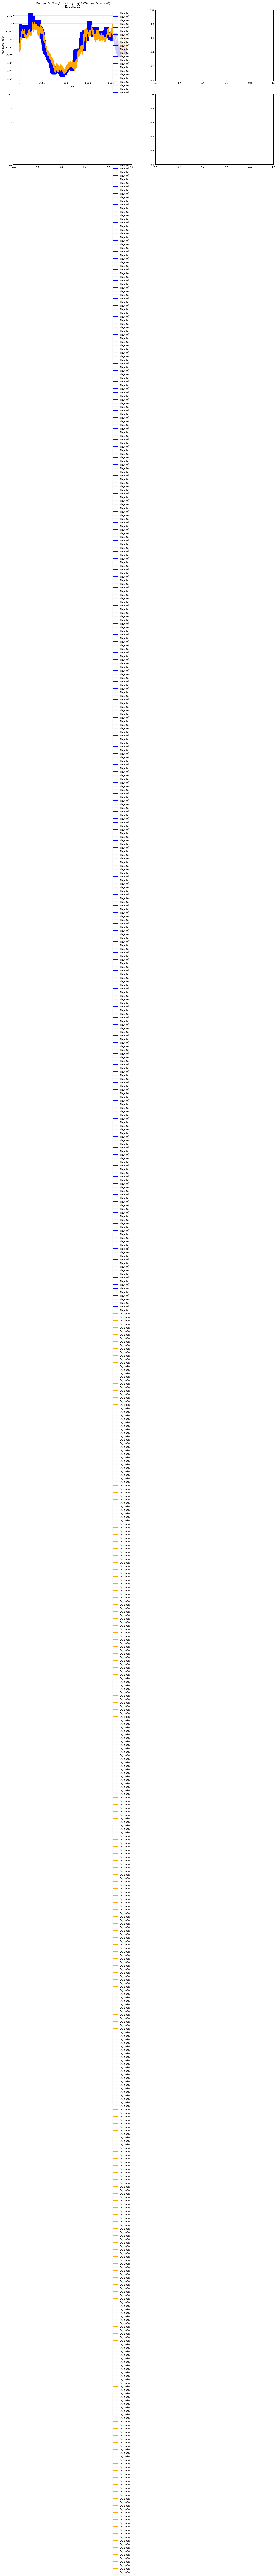

In [ ]:
# VISUALIZATION - 4 biểu đồ cho 4 window sizes (hiển thị past_window * 2)
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.flatten()

for i, result in enumerate(results):
    ax = axes[i]

    # Vẽ đường thực tế và dự đoán
    ax.plot(result['y_test'], label='Thực tế', color='blue', linewidth=1.5)
    ax.plot(result['y_pred'], label='Dự đoán', color='orange', linewidth=1.5)

    # Hiển thị past_window * 2 trong title
    display_window = result['past_window'] * 2

    # Thiết lập title và labels
    ax.set_title(f'Dự báo LSTM mực nước trạm q64 (Window Size: {display_window})\nEpochs: {result["epochs_trained"]}',
                fontsize=12, pad=10)
    ax.set_xlabel('Mẫu')
    ax.set_ylabel('Mực nước (gốc)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
